In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from bqk_utils import *

def standardize_data(data):
    """
    Standardize data to the range [-1, 1].
    """
    data_min = np.min(data)
    data_max = np.max(data)
    if data_max == data_min:
        return np.zeros_like(data)
    standardized = 2 * (data - data_min) / (data_max - data_min) - 1
    return standardized

def plot_seeg_channels(fif_file, duration=10, save_path=None):
    """
    Plot SEEG channels from a .fif file with vertical separation and custom styling.
    
    Parameters:
    - fif_file: Path to the .fif file
    - duration: Duration of data to plot (in seconds)
    - save_path: Path to save the plot (optional, if None, displays plot)
    """
    # Load the .fif file
    raw = mne.io.read_raw_fif(fif_file, preload=True)
    
    # Get sampling frequency and calculate number of samples
    sfreq = raw.info['sfreq']
    n_samples = int(duration * sfreq)
    
    # Extract data (limit to specified duration)
    data, times = raw[:, :n_samples]
    
    # Standardize data to [-1, 1]
    data_standardized = standardize_data(data)
    
    # Number of channels
    n_channels = len(raw.ch_names)
    
    # Vertical offset for each channel
    offset = 2.0
    offsets = np.arange(0, n_channels * offset, offset)
    
    # Define colors: blue tones for electrode 1, red tones for electrode 2
    # Assuming bipolar channels: 0-2 from electrode 1, 3-5 from electrode 2
    colors = []
    for i in range(n_channels):
        if i < n_channels // 2:  # First half (electrode 1)
            cmap = cm.Blues
            shade = 0.4 + (i / (n_channels / 2)) * 0.5  # Range from 0.4 to 0.9
        else:  # Second half (electrode 2)
            cmap = cm.Reds
            shade = 0.4 + ((i - n_channels / 2) / (n_channels / 2)) * 0.5
        colors.append(cmap(shade))
    
    # Create figure
    plt.figure(figsize=(24, n_channels * 1.2))
    
    # Plot each channel
    for i in range(n_channels):
        channel_data = data_standardized[i] + offsets[i]
        plt.plot(times, channel_data, color=colors[i], linewidth=0.8, alpha=0.7)
    
    # Customize plot
    plt.xlim(0, duration)  # Set x-axis from start to end
    plt.xlabel('Time (s)')
    plt.ylabel('Channel')
    plt.title(f'SEEG Data: {fif_file} (First {duration} seconds)')
    
    # Set y-ticks to channel names at their offsets
    plt.yticks(offsets, raw.ch_names)
    
    # Add a subtle grid
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save or display
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
        plt.close()
    else:
        plt.show()

def plot_seeg_with_ieds(fif_file, ied_times, start_time=0, end_time=10, save_path=None):
    """
    Plot SEEG channels with IED time ranges marked by red lines.

    Parameters:
    - fif_file (str): Path to the .fif file containing SEEG data.
    - ied_times (list): List of IED time ranges per channel from find_high_enveTimes.
    - start_time (float): Start time of the plot in seconds (default 0).
    - end_time (float): End time of the plot in seconds (default 10).
    - save_path (str, optional): Path to save the plot; if None, displays it.
    """
    # Load SEEG data
    raw = mne.io.read_raw_fif(fif_file, preload=True)
    sfreq = raw.info['sfreq']
    start_idx = int(start_time * sfreq)
    end_idx = int(end_time * sfreq)

    # Extract data and times for the specified range
    data, times = raw[:, start_idx:end_idx]
    data_standardized = standardize_data(data)
    n_channels = len(raw.ch_names)
    times = times - times[0] + start_time  # Adjust times to start from start_time

    # Define vertical offsets and colors
    offset = 2.5  # Increased offset for clearer separation
    offsets = np.arange(0, n_channels * offset, offset)
    colors = []
    for i in range(n_channels):
        if i < n_channels // 2:  # First electrode (blue tones)
            cmap = cm.Blues
            shade = 0.4 + (i / (n_channels / 2)) * 0.5
        else:  # Second electrode (red tones)
            cmap = cm.Reds
            shade = 0.4 + ((i - n_channels / 2) / (n_channels / 2)) * 0.5
        colors.append(cmap(shade))

    # Create plot
    plt.figure(figsize=(24, n_channels * 1.5))  # Adjusted height for separation

    # Plot each channel
    for i in range(n_channels):
        channel_data = data_standardized[i] + offsets[i]
        plt.plot(times, channel_data, color=colors[i], linewidth=0.8, alpha=0.7)

        # Mark IED events with red lines
        if i < len(ied_times) and ied_times[i]:  # Check if channel has IEDs
            for ied_start, ied_end in ied_times[i]:
                if ied_start <= end_time and ied_end >= start_time:  # Within plot range
                    # Limit span to plot bounds
                    plot_start = max(ied_start, start_time)
                    plot_end = min(ied_end, end_time)
                    # Vertical red lines at start and end with transparency
                    plt.axvline(x=plot_start, color='red', alpha=0.5, linestyle='--', linewidth=1.5)
                    plt.axvline(x=plot_end, color='red', alpha=0.5, linestyle='--', linewidth=1.5)

    # Customize plot
    plt.xlim(start_time, end_time)  # Set x-axis from start_time to end_time
    plt.xlabel('Time (s)')
    plt.ylabel('Channels')
    plt.title(f'SEEG Data with IEDs: {os.path.basename(fif_file)} ({start_time}-{end_time} s)')
    plt.yticks(offsets, raw.ch_names)  # Channel names on y-axis
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()

    # Save or display
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Plot saved to {save_path}")
    else:
        plt.show()

Opening raw data file preprocessed/bipolar/24_08_13-D_21_00_00_bipolar.fif...
    Range : 0 ... 1964999 =      0.000 ...  1964.999 secs
Ready.
Reading 0 ... 1964999  =      0.000 ...  1964.999 secs...


/tmp/ipykernel_461902/1501477807.py:28: RuntimeWarning: This filename (preprocessed/bipolar/24_08_13-D_21_00_00_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


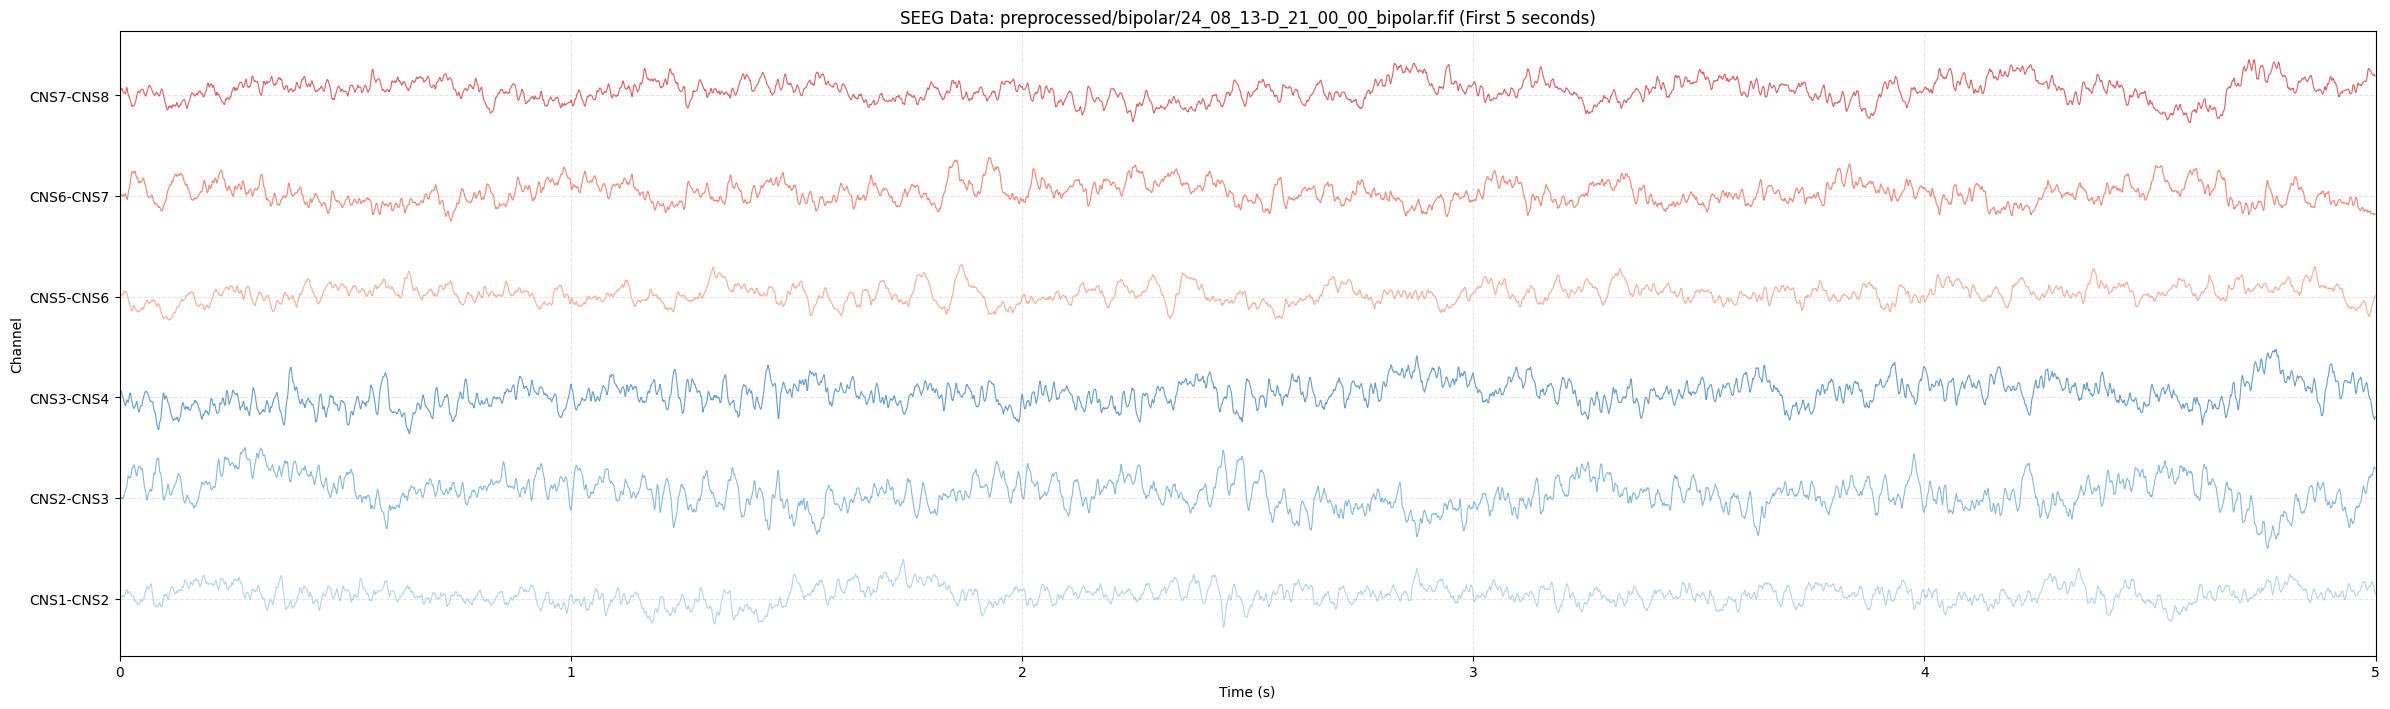

In [20]:
# Example usage
fif_file = 'preprocessed/bipolar/24_08_13-D_21_00_00_bipolar.fif'  # Replace with your .fif file path
plot_duration = 5  # Plot 10 seconds of data
# save_path = './plots/test_bipolar_standardized.png'  # Optional save path

try:
    plot_seeg_channels(fif_file, duration=plot_duration)
except FileNotFoundError:
    print(f"Error: The file {fif_file} was not found. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

In [25]:
raw = mne.io.read_raw_fif(fif_file, preload=True)
fs = raw.info['sfreq']  # Sampling frequency (e.g., 1000 Hz)

# Step 2: Compute envelope for IED detection
# We'll use a broad frequency band (e.g., 30-150 Hz) for IEDs
freq_band = [80, 450]
raw_enve = return_hil_enve_norm(raw.get_data(), fs, freq_band)


Opening raw data file preprocessed/bipolar/24_08_13-D_21_00_00_bipolar.fif...
    Range : 0 ... 1964999 =      0.000 ...  1964.999 secs
Ready.
Reading 0 ... 1964999  =      0.000 ...  1964.999 secs...


/tmp/ipykernel_461902/85060333.py:1: RuntimeWarning: This filename (preprocessed/bipolar/24_08_13-D_21_00_00_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


Opening raw data file preprocessed/bipolar/24_08_13-D_21_00_00_bipolar.fif...
    Range : 0 ... 1964999 =      0.000 ...  1964.999 secs
Ready.
Reading 0 ... 1964999  =      0.000 ...  1964.999 secs...


/tmp/ipykernel_461902/1501477807.py:102: RuntimeWarning: This filename (preprocessed/bipolar/24_08_13-D_21_00_00_bipolar.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


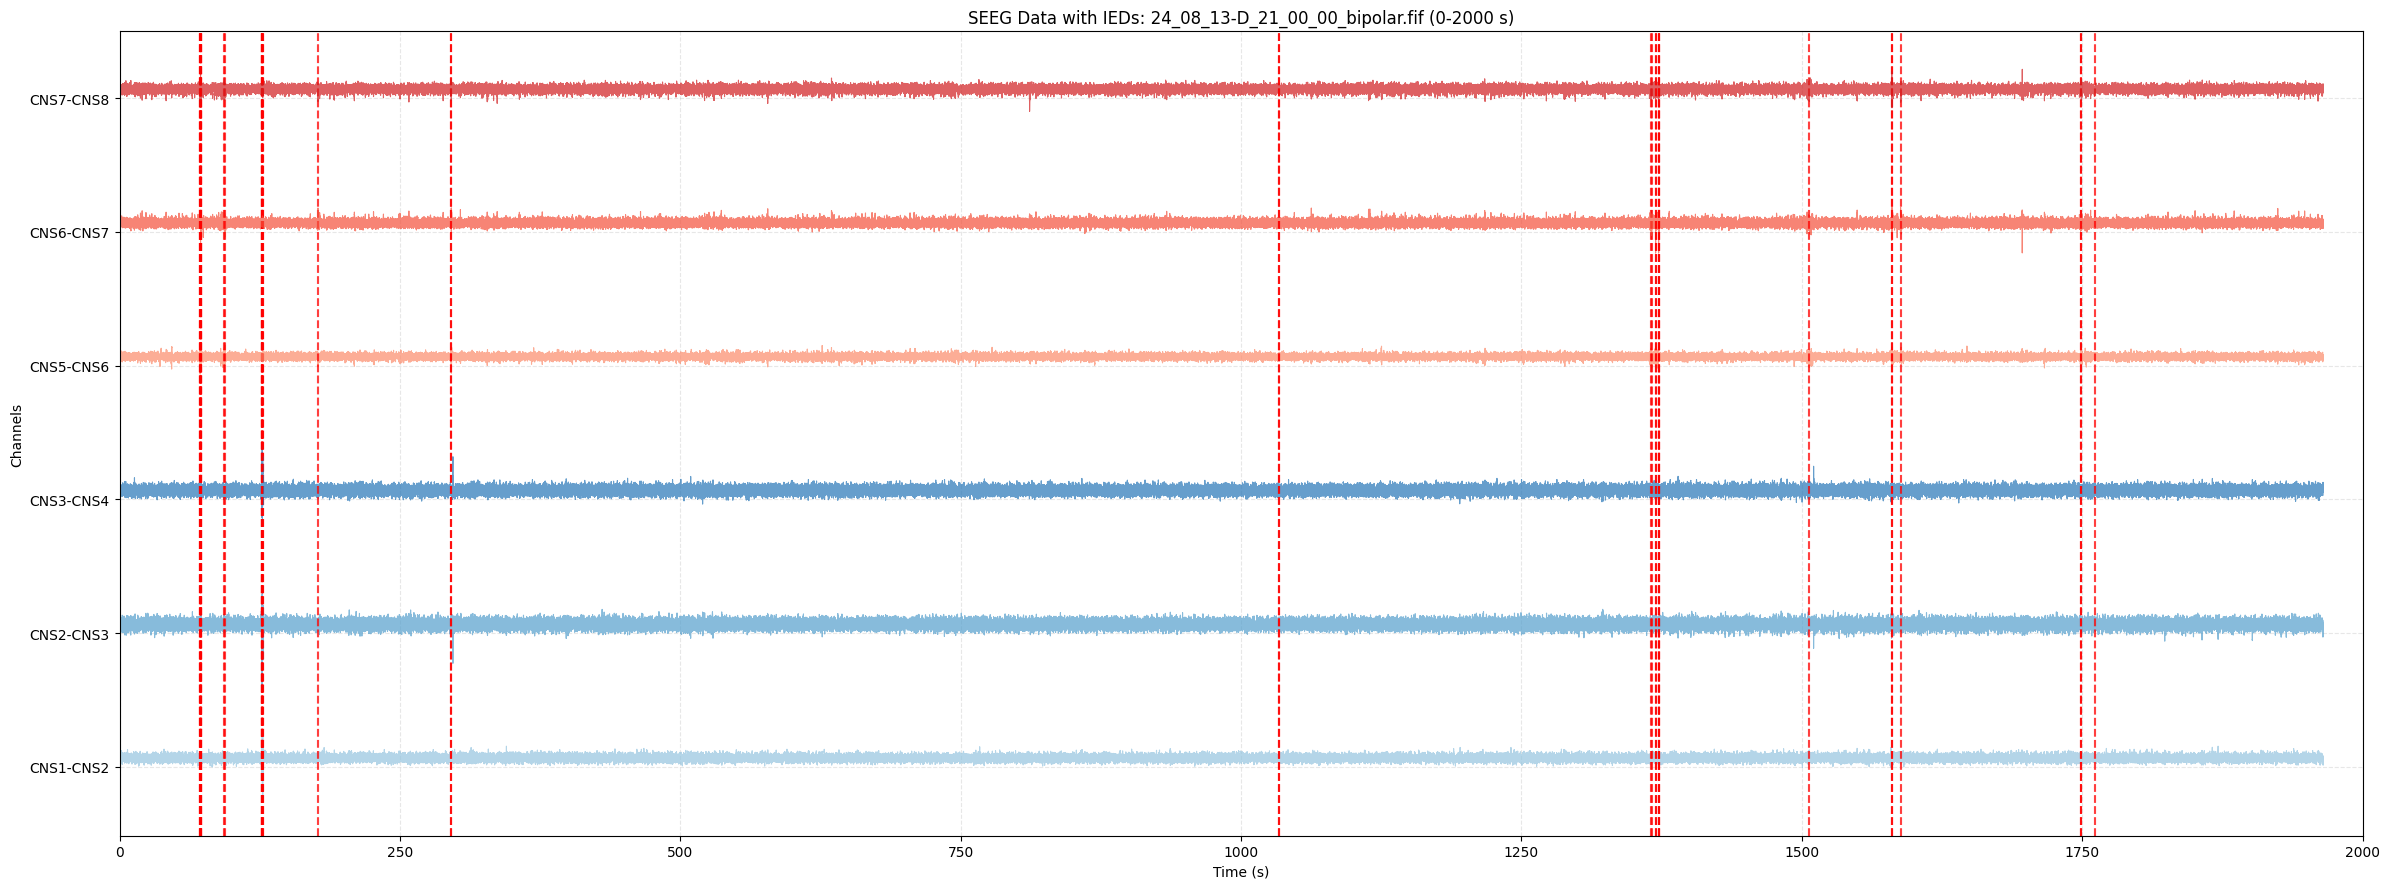

In [28]:
# Step 3: Detect IED time ranges
n_channels = len(raw.ch_names)
high_times = find_high_enveTimes(
    raw_enve=raw_enve,
    chns_nums=n_channels,
    fs=fs,
    rel_thresh=3,      # Relative threshold
    abs_thresh=3,      # Absolute threshold
    min_gap=10,          # Minimum gap in ms
    min_last=10,         # Minimum duration in ms
    start_time=0
)

# Call the plotting function
plot_seeg_with_ieds(
    fif_file=fif_file,
    ied_times=high_times,
    start_time= 0,
    end_time= 2000)